# 6. Feature engineering
Lets decompose the hourly electricity demand into three additive components:
- trend
- season
- residual

## Setup and imports


In [1]:
from functions import *
from statsmodels.tsa.seasonal import seasonal_decompose

## Load the data

In [2]:
df = load_data()
df = df.sort_index()
demand = df["demand"].asfreq("h").to_frame(name="demand")
demand = demand.interpolate(limit_direction="both")

## Classical additive decomposition


Decomposition with period: 24 hours

Decomposition with period: 168 hours

Decomposition with period: 720 hours


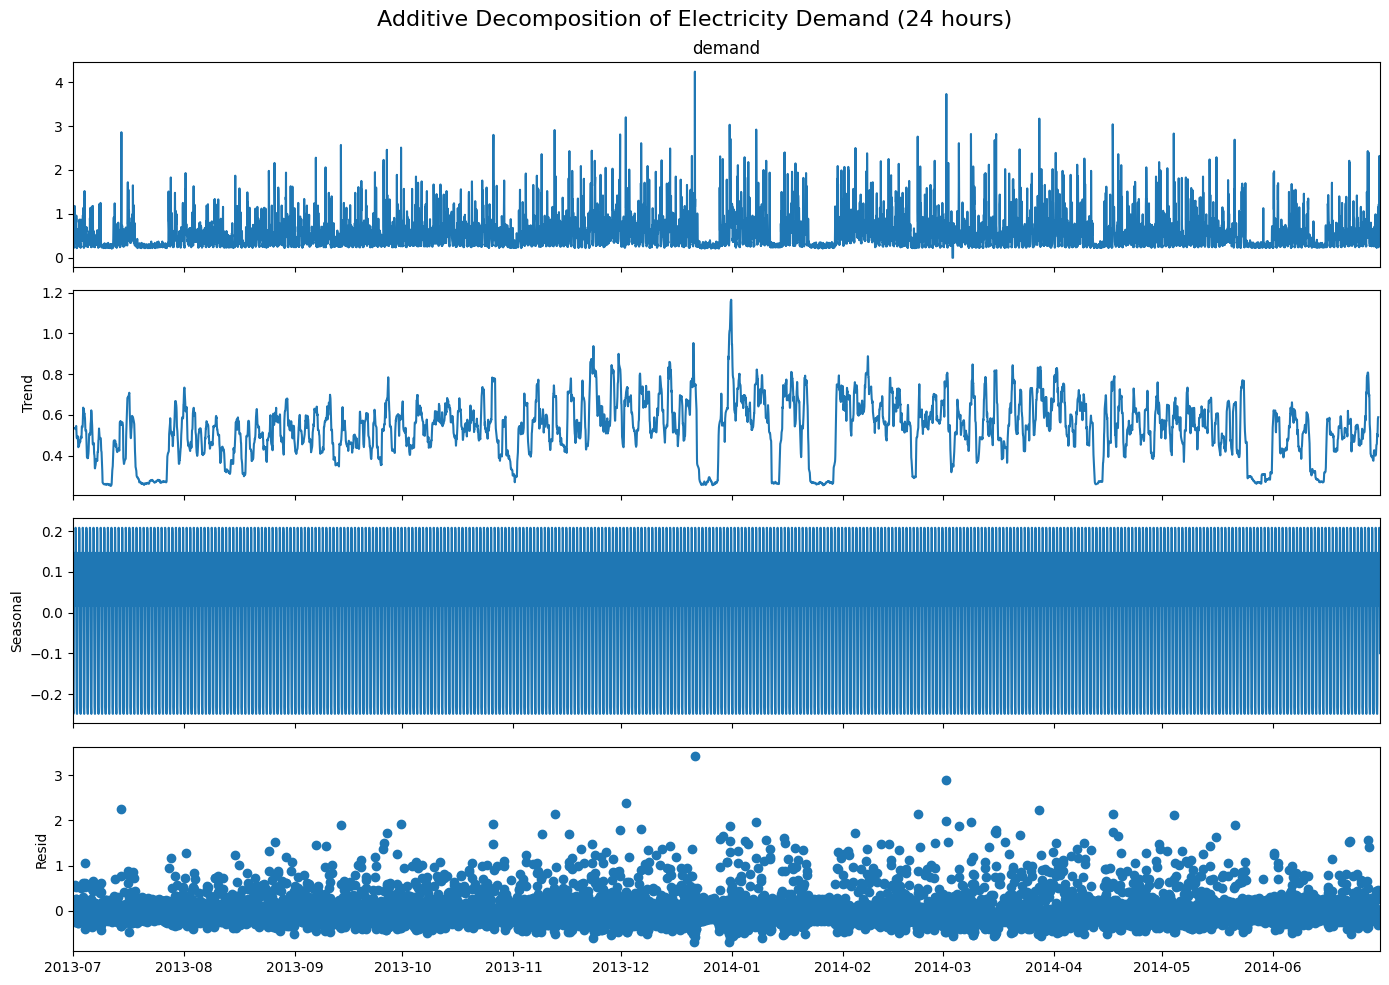

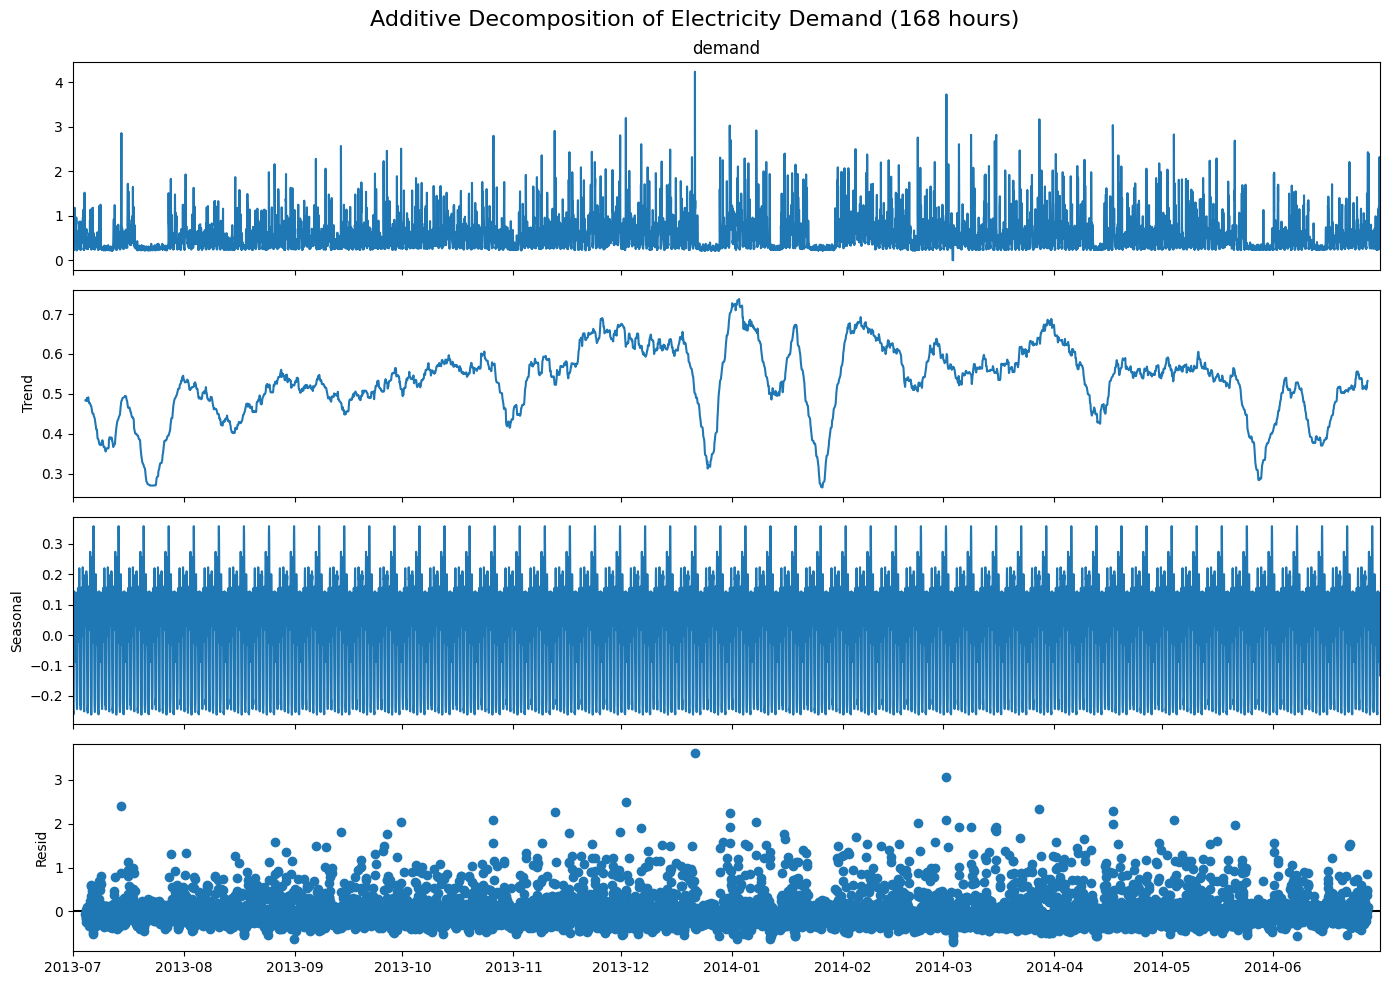

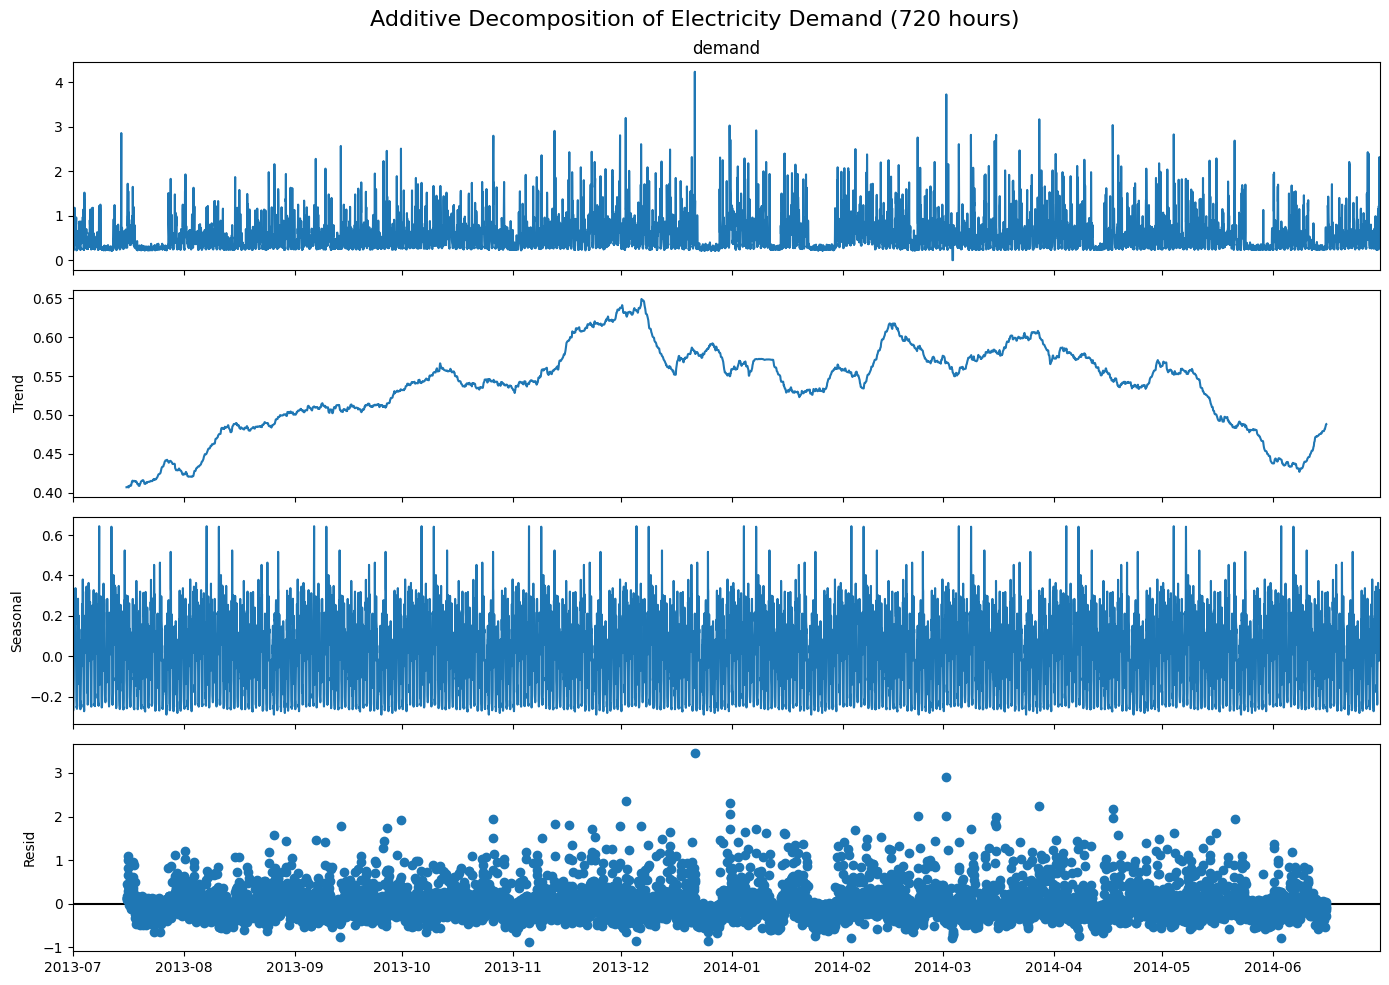

In [3]:
periods = [24, 168, 720]
decomposition_results = {}

for period in periods:
    print(f"\nDecomposition with period: {period} hours")

    decomposition = seasonal_decompose(
        demand['demand'],
        model='additive',
        period=period
    )

    decomposition_results[period] = decomposition

    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.suptitle(
        f'Additive Decomposition of Electricity Demand ({period} hours)',
        fontsize=16
    )
    plt.tight_layout()
    save_fig(fig, f'ex6_fig1_decomposition_{period}.svg')

In [4]:
def seasonality_strength(result):
    resid_var = np.var(result.resid.dropna())
    combined_var = np.var((result.resid + result.seasonal).dropna())
    return 1 - resid_var / combined_var

for p, r in decomposition_results.items():
    strength = seasonality_strength(r)
    print(f"Seasonality strength ({p}h): {strength:.3f}")

Seasonality strength (24h): 0.200
Seasonality strength (168h): 0.200
Seasonality strength (720h): 0.247


## Compare decomposition periods for electricity demand insights:

In [5]:
for period, decomposition in decomposition_results.items():
    seasonal_variance = decomposition.seasonal.var()
    residual_variance = decomposition.resid.var()
    explained_ratio = seasonal_variance / \
        (seasonal_variance + residual_variance)

    print(f"Period {period} hours:")
    print(f" - Seasonal variance: {seasonal_variance:.2f}")
    print(f" - Residual variance: {residual_variance:.2f}")
    print(f" - Seasonal variance explained ratio: {explained_ratio:.2%}\n")

optimal_period = max(decomposition_results, key=lambda p: decomposition_results[p].seasonal.var(
) / (decomposition_results[p].seasonal.var() + decomposition_results[p].resid.var()))

print(
    f"The optimal decomposition period for electricity demand analysis is {optimal_period} hours.")

Period 24 hours:
 - Seasonal variance: 0.02
 - Residual variance: 0.10
 - Seasonal variance explained ratio: 20.00%

Period 168 hours:
 - Seasonal variance: 0.03
 - Residual variance: 0.10
 - Seasonal variance explained ratio: 20.01%

Period 720 hours:
 - Seasonal variance: 0.04
 - Residual variance: 0.11
 - Seasonal variance explained ratio: 24.79%

The optimal decomposition period for electricity demand analysis is 720 hours.


---
## 3. Typical demand profiles

- Average hourly demand of each month

'images/ex6_fig_2_hourly_demand_for_each_month.svg'

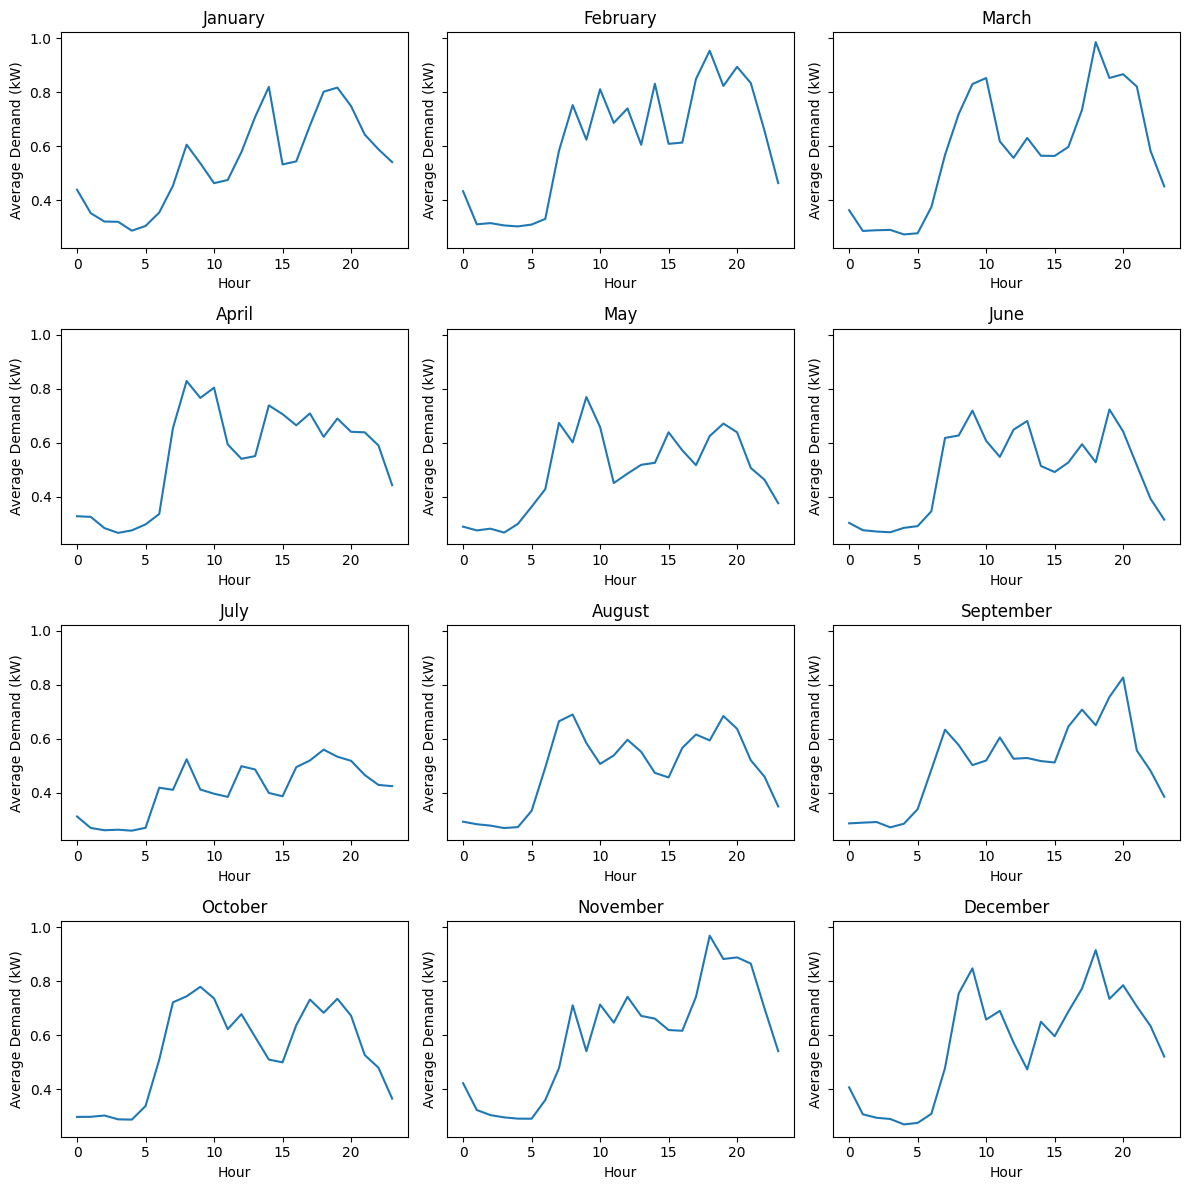

In [6]:
demand['month'] = demand.index.month
demand['hour'] = demand.index.hour
demand["day"] = demand.index.date

month_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September","October", "November", "December"]

# Group by month and hour, then calculate the mean for each month-hour combination
monthly_avg = demand.groupby(['month', 'hour'])['demand'].mean().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for month in range(1, 13):
    ax = axes[month - 1]
    month_data = monthly_avg[monthly_avg['month'] == month]

    ax.plot(month_data['hour'], month_data['demand'])
    ax.set_title(month_labels[month - 1])
    ax.set_xlabel('Hour')
    ax.set_ylabel('Average Demand (kW)')
plt.tight_layout()
save_fig(fig, "ex6_fig_2_hourly_demand_for_each_month.svg")

- Average hourly demand by season

'images/ex6_fig_3_hourly_demand_by_season.svg'

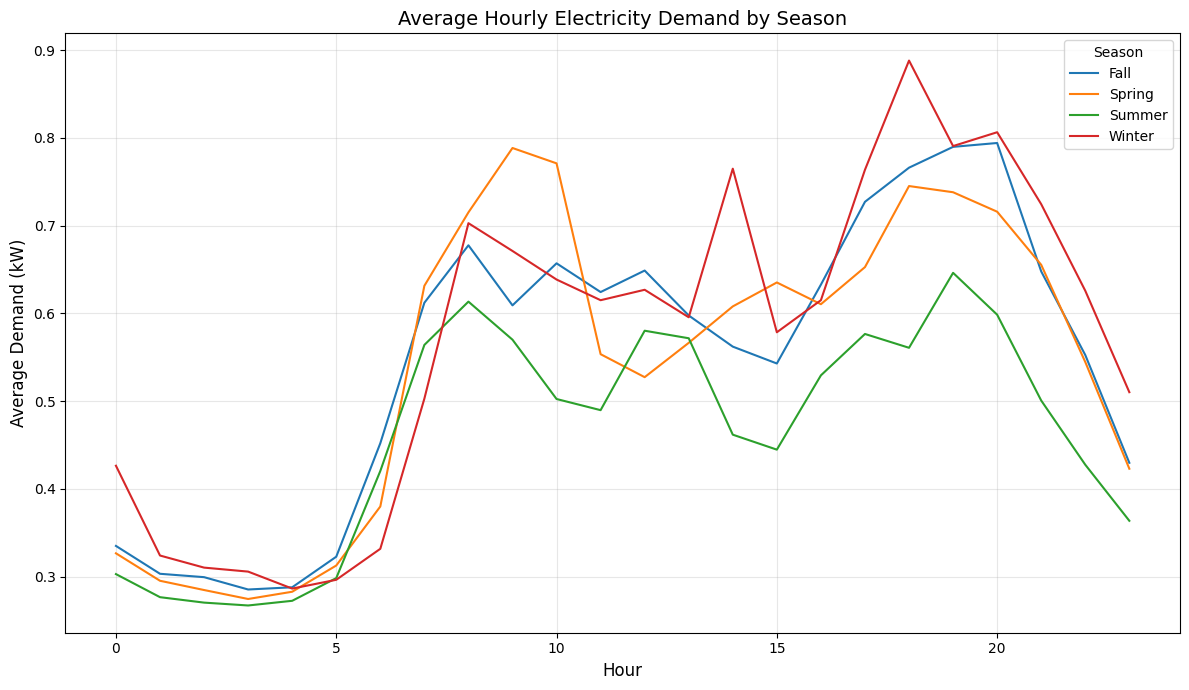

In [7]:
demand['season'] = demand['month'].apply(get_season)
seasonal_profiles = (
    demand.groupby(['hour', 'season'])['demand']
    .mean()
    .unstack('season')
)

fig = plt.figure(figsize=(12, 7))
seasonal_profiles.plot(ax=plt.gca())
plt.title('Average Hourly Electricity Demand by Season', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Average Demand (kW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Season')
plt.tight_layout()
save_fig(fig, "ex6_fig_3_hourly_demand_by_season.svg")

- Average hourly demand - weekday vs weekend

'images/ex6_fig_4_hourly_demand_weekday_vs_weekend.svg'

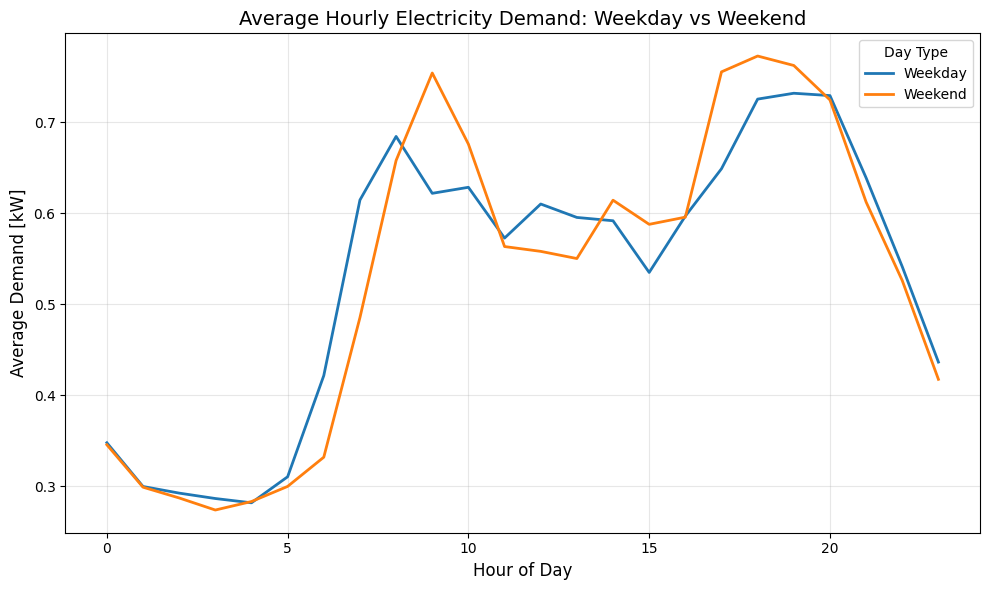

In [8]:
demand['day_of_week'] = demand.index.dayofweek
demand['is_weekend'] = demand['day_of_week'] >= 5
demand['day_type'] = demand['is_weekend'].map({False: 'Weekday', True: 'Weekend'})

weekday_profile = (
    demand.groupby(['hour', 'day_type'])['demand']
    .mean()
    .unstack('day_type')
)

plt.figure(figsize=(10, 6))
weekday_profile.plot(ax=plt.gca(), linewidth=2)
plt.title('Average Hourly Electricity Demand: Weekday vs Weekend', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Demand [kW]', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Day Type')
plt.tight_layout()
save_fig(fig, "ex6_fig_4_hourly_demand_weekday_vs_weekend.svg")

---
## 4. Methodology Explanation
Hourly electricity demand data were indexed by timestamp and converted to a continuous hourly frequency.
Small gaps were filled by interpolation to ensure data completeness.
Time-based features — *month*, *hour*, *day*, *season*, and *weekday/weekend* — were extracted from the index.

**Monthly Profiles:**
The data were grouped by month and hour (`groupby(['month','hour'])`) to calculate the mean hourly demand for each month.
This produced 12 average daily profiles, one for each month, visualized as separate subplots.

**Seasonal Profiles:**
A seasonal label was assigned to each observation using the `get_season()` function.
Average hourly demand for each season was computed (`groupby(['hour','season'])`) and plotted on a single chart to highlight seasonal variation.

**Weekday vs Weekend:**
Each timestamp was classified as either a weekday or weekend based on `day_of_week`.
Average hourly demand for both categories was compared to reveal behavioural differences in daily usage patterns.

**Purpose:**
These profiles illustrate how typical electricity consumption changes by month, season, and day type,
supporting better understanding of temporal demand patterns for forecasting.

---
## Conclusion
- The results indicate that the 720-hour period (approximately one month) explains the largest share of demand variation (~ 25%).
